IMPORT TIME

In [58]:
import numpy as np
import pandas as pd
import yfinance as yf # library for all of the stock data
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

In [59]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print (device)

cpu


Showcase into the yfinance library we will be using and how the data is presented to us

In [ ]:
ticker = 'AAPL' # ticker is a key for any company on the stock exchange
df = yf.download(ticker, '2020-01-01')
print(df)

In [ ]:
df.Close.plot(figsize = (12,8))

PREPROCESSING TIME

In [ ]:
# scaling the data so it has a normal distribution
# mean = 0, standard deviation = 1
scaler = StandardScaler()

df['Close'] = scaler.fit_transform(df['Close'])
print (df['Close'])

In [ ]:
seq_length = 30 # how many items we want to look at for a given time, with the final value being predicted
data = []

for i in range(len(df) - seq_length):
    data.append(df.Close[i:i+seq_length])

#turn this data into a numpy array
data = np.array(data)
print (data)

In [64]:
train_size = int(0.8 * len(data)) # train split - 80%

x_train = torch.from_numpy(data[:train_size, :-1, :]).type(torch.Tensor).to(device)
y_train = torch.from_numpy(data[:train_size, -1, :]).type(torch.Tensor).to(device)
x_test = torch.from_numpy(data[train_size:, :-1, :]).type(torch.Tensor).to(device)
y_test = torch.from_numpy(data[train_size:, -1, :]).type(torch.Tensor).to(device)

In [65]:
class PredictionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(PredictionModel, self).__init__()

        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True) #first LSTM layer
        self.fc = nn.Linear(hidden_dim, output_dim) # then linear layer 


    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)

        out, (hn,cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])

        return out

In [66]:
model = PredictionModel(input_dim=1, hidden_dim=32, num_layers=2, output_dim=1).to(device)

In [67]:
#using RMSE loss (Root Mean Squared Error)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:
num_epochs = 201

for i in range (num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train)

    if i % 25 == 0:
        print (i, loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [69]:
# visualise model against

model.eval()

y_test_pred = model(x_test)

y_train_pred = scaler.inverse_transform(y_train_pred.detach().cpu().numpy())
y_train = scaler.inverse_transform(y_train.detach().cpu().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().cpu().numpy())
y_test = scaler.inverse_transform(y_test.detach().cpu().numpy())

In [ ]:
train_rmse = root_mean_squared_error(y_train[:, 0], y_train_pred[:, 0])
test_rmse = root_mean_squared_error(y_test[:, 0], y_test_pred[:, 0])

print(train_rmse)
print(test_rmse)

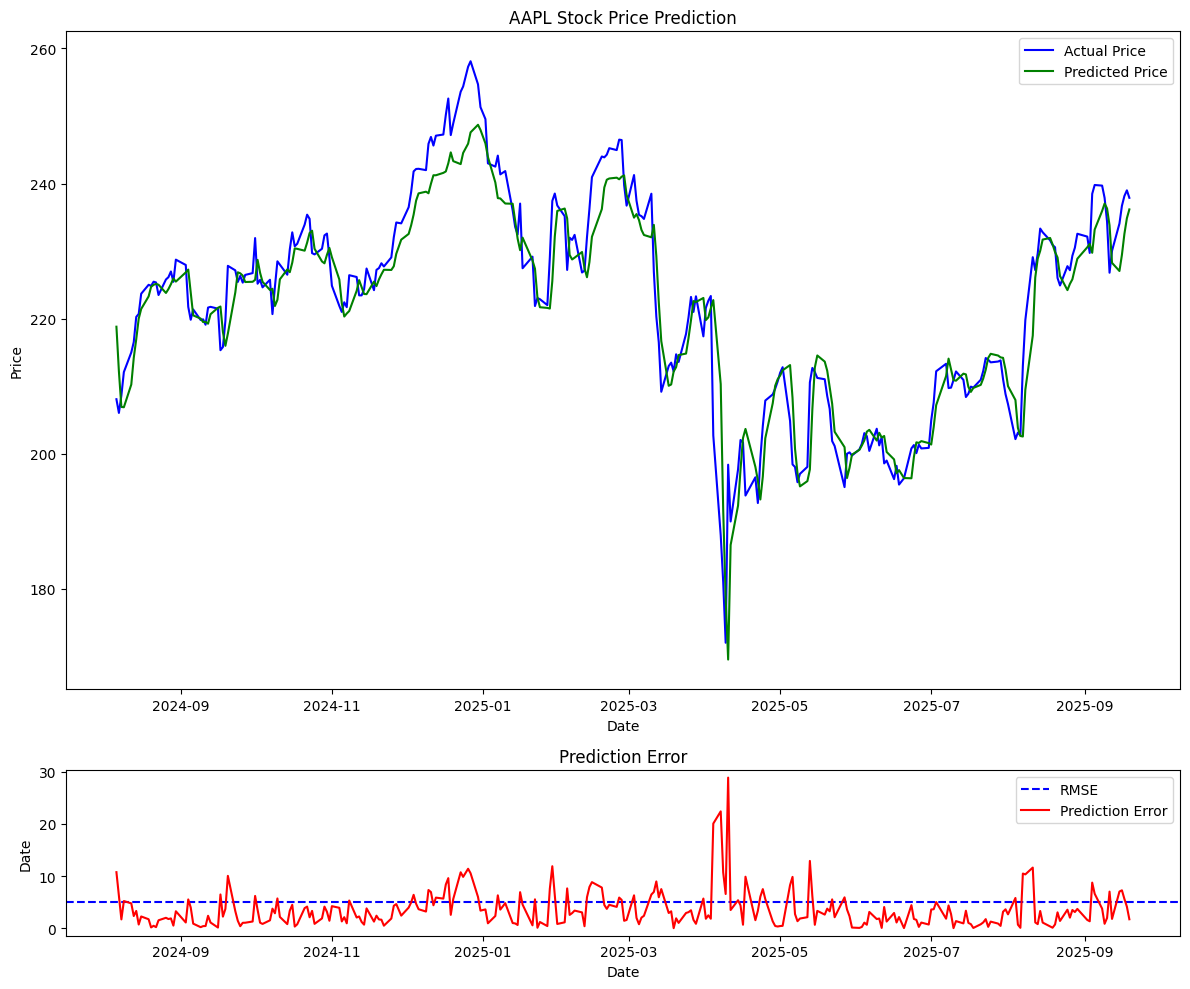

In [73]:
fig = plt.figure(figsize=(12,10))

gs = fig.add_gridspec(4,1)

ax1 = fig.add_subplot(gs[:3,0])
ax1.plot(df.iloc[-len(y_test):].index, y_test, color = 'blue', label = 'Actual Price')
ax1.plot(df.iloc[-len(y_test):].index, y_test_pred, color = 'green', label = 'Predicted Price')
ax1.legend()
plt.title(f"{ticker} Stock Price Prediction")
plt.xlabel('Date')
plt.ylabel('Price')

ax2 = fig.add_subplot(gs[3, 0])
ax2.axhline(test_rmse, color='blue', linestyle='--', label='RMSE')
ax2.plot(df[-len(y_test):].index, abs(y_test - y_test_pred), 'r', label='Prediction Error')
ax2.legend()
plt.title('Prediction Error')
plt.xlabel('Date')
plt.ylabel('Date')
plt.tight_layout()

plt.show()
